引入葡萄酒數據集，並給予適當的title

In [2]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('wine.data', header=None) # open the wine dataset

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


接下來兩個block，我們學習怎麼產生標準化與正規化的訓練集

In [3]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values # X is the feature, y is the class label

# Split 30% of the dataset to testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Generate the normalized dataset
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

# generate the standardlized dataset
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

並且用邏輯斯回歸預測，發現正確率十分高。我們給予模型L1的懲罰。

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


在如此的懲罰之下，我們藉由以下程式觀察各個特徵的係數隨著C值變化的情形。

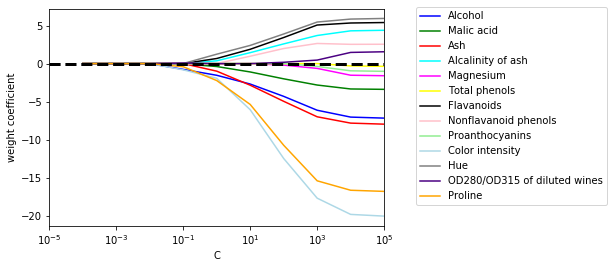

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0, solver='liblinear', multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
#plt.savefig('images/04_07.png', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

由於13個特徵實在是太多了，很容易因此產生過度適合的現象。為了解決這個問題，我們發想：或許只要選擇幾個特別重要的特徵，便可得到效能不差的分類氣。此種觀念稱為$\textbf{特徵選擇}$。而$\textbf{循序向後選擇演算法}$(SBS algorithm)即是此觀念之實作。然而，scikit learn並沒有這個演算法。我們需要手刻一個：

In [13]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features #一次丟幾個feature
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

來使用SBS演算法對KNN以及邏輯斯回歸進行評估。我們發現KNN只要三個，而邏輯斯回歸只要7個便能達成100%的預測正確率。

In [24]:
import matplotlib.pyplot as plt

def plot_feature_accuracy(sbs_set):
    # plotting performance of feature subsets
    k_feat = [len(k) for k in sbs_set.subsets_]

    plt.plot(k_feat, sbs_set.scores_, marker='o')
    plt.ylim([0.7, 1.02])
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    plt.grid()
    plt.tight_layout()
    # plt.savefig('images/04_08.png', dpi=300)
    plt.show()

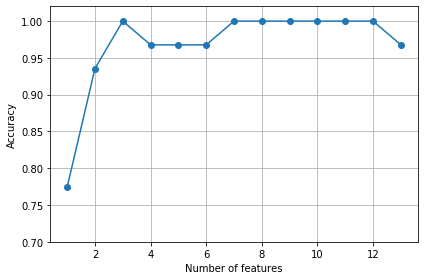

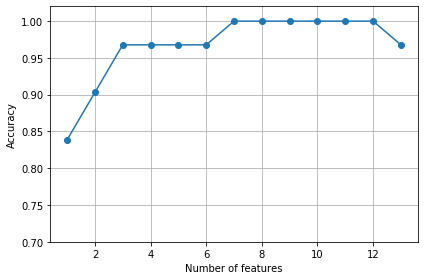

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(penalty='l2', C=10.**c, random_state=0, solver='lbfgs', multi_class='ovr', max_iter=100)

# selecting features
sbs1 = SBS(knn, k_features=1)
sbs2 = SBS(lr, k_features=1)
sbs1.fit(X_train_std, y_train)
sbs2.fit(X_train_std, y_train)

# Plot accuracy v.s. number of features
plot_feature_accuracy(sbs_set=sbs1)
plot_feature_accuracy(sbs_set=sbs2)

於是我們好奇是只要取哪些特徵就好？這樣訓練出的分類器效能相較原本的性能又如何呢？我們同時以訓練集與測試集做測試

In [34]:
# 找出是哪些特徵就夠用
k3 = list(sbs1.subsets_[10])
print(df_wine.columns[1:][k3])
k7 = list(sbs2.subsets_[6])
print(df_wine.columns[1:][k7])

# KNN演算法：只對3個特徵
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

# KNN演算法：特徵全下
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

# 邏輯斯回歸：只對7個特徵
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

# 邏輯斯回歸：特徵全下
lr.fit(X_train_std[:, k7], y_train)
print('Training accuracy:', lr.score(X_train_std[:, k7], y_train))
print('Test accuracy:', lr.score(X_test_std[:, k7], y_test))

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')
Index(['Alcohol', 'Malic acid', 'Ash', 'Flavanoids', 'Nonflavanoid phenols',
       'Color intensity', 'Proline'],
      dtype='object')
Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629
Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259
Training accuracy: 1.0
Test accuracy: 1.0
Training accuracy: 1.0
Test accuracy: 0.9444444444444444


最後，我們利用random forest來找出各個特徵之間的重要性排名。並用數值表達之。

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


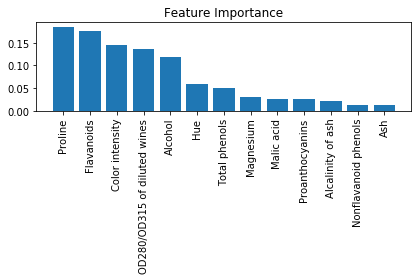

In [35]:
from sklearn.ensemble import RandomForestClassifier

#繪製特徵重要度的長條圖
feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_ #計算各特徵重要度

indices = np.argsort(importances)[::-1] 

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

sklearn裡面有一SelectFromModel物件可以讓我們挑選想要的特徵。

In [36]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True) #根據上個block計算，重要度超過門檻值(可自選，此取0.1)才選入模型中
X_selected = sfm.transform(X_train)

#列出哪些模型重要度超過門檻
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

Number of features that meet this threshold criterion: 5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
